# RAG Pipeline with Guardrails

This notebook demonstrates how to build a **Contextual Semantic Search** system using **Chroma Vector Database** and **LiteLLM** with the **Gemini model**. The system processes a folder of PDF documents, builds a knowledge base, and retrieves contextually relevant information to answer user queries. Additionally, it includes **guardrails** to ensure the system's safety and reliability by detecting toxic content, adversarial patterns, and personally identifiable information (PII). Below is an overview of the tools and methods used.

## Tools Used

### Chroma Vector Database:
- A vector database designed for storing and querying embeddings.
- Enables efficient similarity search for retrieving semantically relevant documents.

### Sentence Transformers:
- A library for generating high-quality embeddings (vector representations) of text.
- Uses pre-trained models like `all-MiniLM-L6-v2` to convert text into embeddings.

### LangChain:
- A framework for working with text data, including text splitting and chunking.
- The `RecursiveCharacterTextSplitter` is used to split text into semantically meaningful chunks.

### LiteLLM:
- A lightweight library for interacting with large language models (LLMs).
- Used here to call the **Gemini model** for generating responses based on retrieved context.

### PyPDF2:
- A library for extracting text from PDF files.
- Used to process all PDFs in a specified folder.

### Detoxify:
- A library for detecting toxic content in text.
- Used to ensure that user queries do not contain inappropriate or harmful language.

### Presidio:
- A library for detecting and redacting personally identifiable information (PII) in text.
- Ensures that sensitive information is not exposed in the system's responses.

### Regular Expressions (Regex):
- Used to detect adversarial patterns in user queries, such as special characters or scripts.

## Methods and Steps

### Step 1: Extract Text from PDFs
- All PDF files in a specified folder are processed using **PyPDF2**.
- The text from each PDF is extracted and combined into a single string.

### Step 2: Split Text into Chunks
- The combined text is split into smaller chunks using **LangChain's RecursiveCharacterTextSplitter**.
- This ensures that the chunks are semantically meaningful and retain context.

### Step 3: Generate Embeddings
- Each text chunk is converted into an embedding (vector representation) using **Sentence Transformers**.
- The embeddings capture the semantic meaning of the text.

### Step 4: Build the Knowledge Base
- The embeddings and corresponding text chunks are stored in **Chroma Vector Database**.
- This allows for efficient similarity searches based on semantic meaning.

### Step 5: Perform Semantic Search
- A user query is converted into an embedding.
- The most semantically similar chunks are retrieved from the **Chroma database**.

### Step 6: Generate Responses
- The retrieved chunks are passed as context to the **Gemini model** via **LiteLLM**.
- The model generates a response based on the query and the provided context.

### Step 7: Guardrails for Safety and Reliability
- **Input Validation**: The system checks for toxic content in user queries using **Detoxify**.
- **Adversarial Pattern Detection**: The system uses **Regex** to detect unusual patterns or special characters in queries.
- **PII Detection and Redaction**: The system uses **Presidio** to detect and redact personally identifiable information (PII) in the retrieved context.
- **Response Length Limit**: The system ensures that the generated response does not exceed a specified length limit.

## Workflow Overview

1. **Input**: A folder containing PDF documents.
2. **Processing**:
   - Extract text from PDFs.
   - Split text into chunks.
   - Generate embeddings and store them in Chroma.
3. **Query Handling**:
   - Convert the query into an embedding.
   - Retrieve the most relevant chunks from Chroma.
   - Generate a response using the Gemini model.
4. **Guardrails**:
   - Validate input for toxic content.
   - Detect adversarial patterns in the query.
   - Detect and redact PII in the retrieved context.
   - Ensure the response does not exceed the length limit.
5. **Output**: A contextually accurate and safe answer to the user's query.

## Why This Approach?

- **Contextual Semantic Search**: Goes beyond keyword matching to understand the meaning and context of the query.
- **Efficient Retrieval**: Chroma enables fast and scalable similarity searches.
- **High-Quality Responses**: The Gemini model generates accurate and contextually relevant answers.
- **Safety and Reliability**: Guardrails ensure that the system is safe from toxic content, adversarial attacks, and PII exposure.

Let’s get started! Below is the simple explanation for what we build.

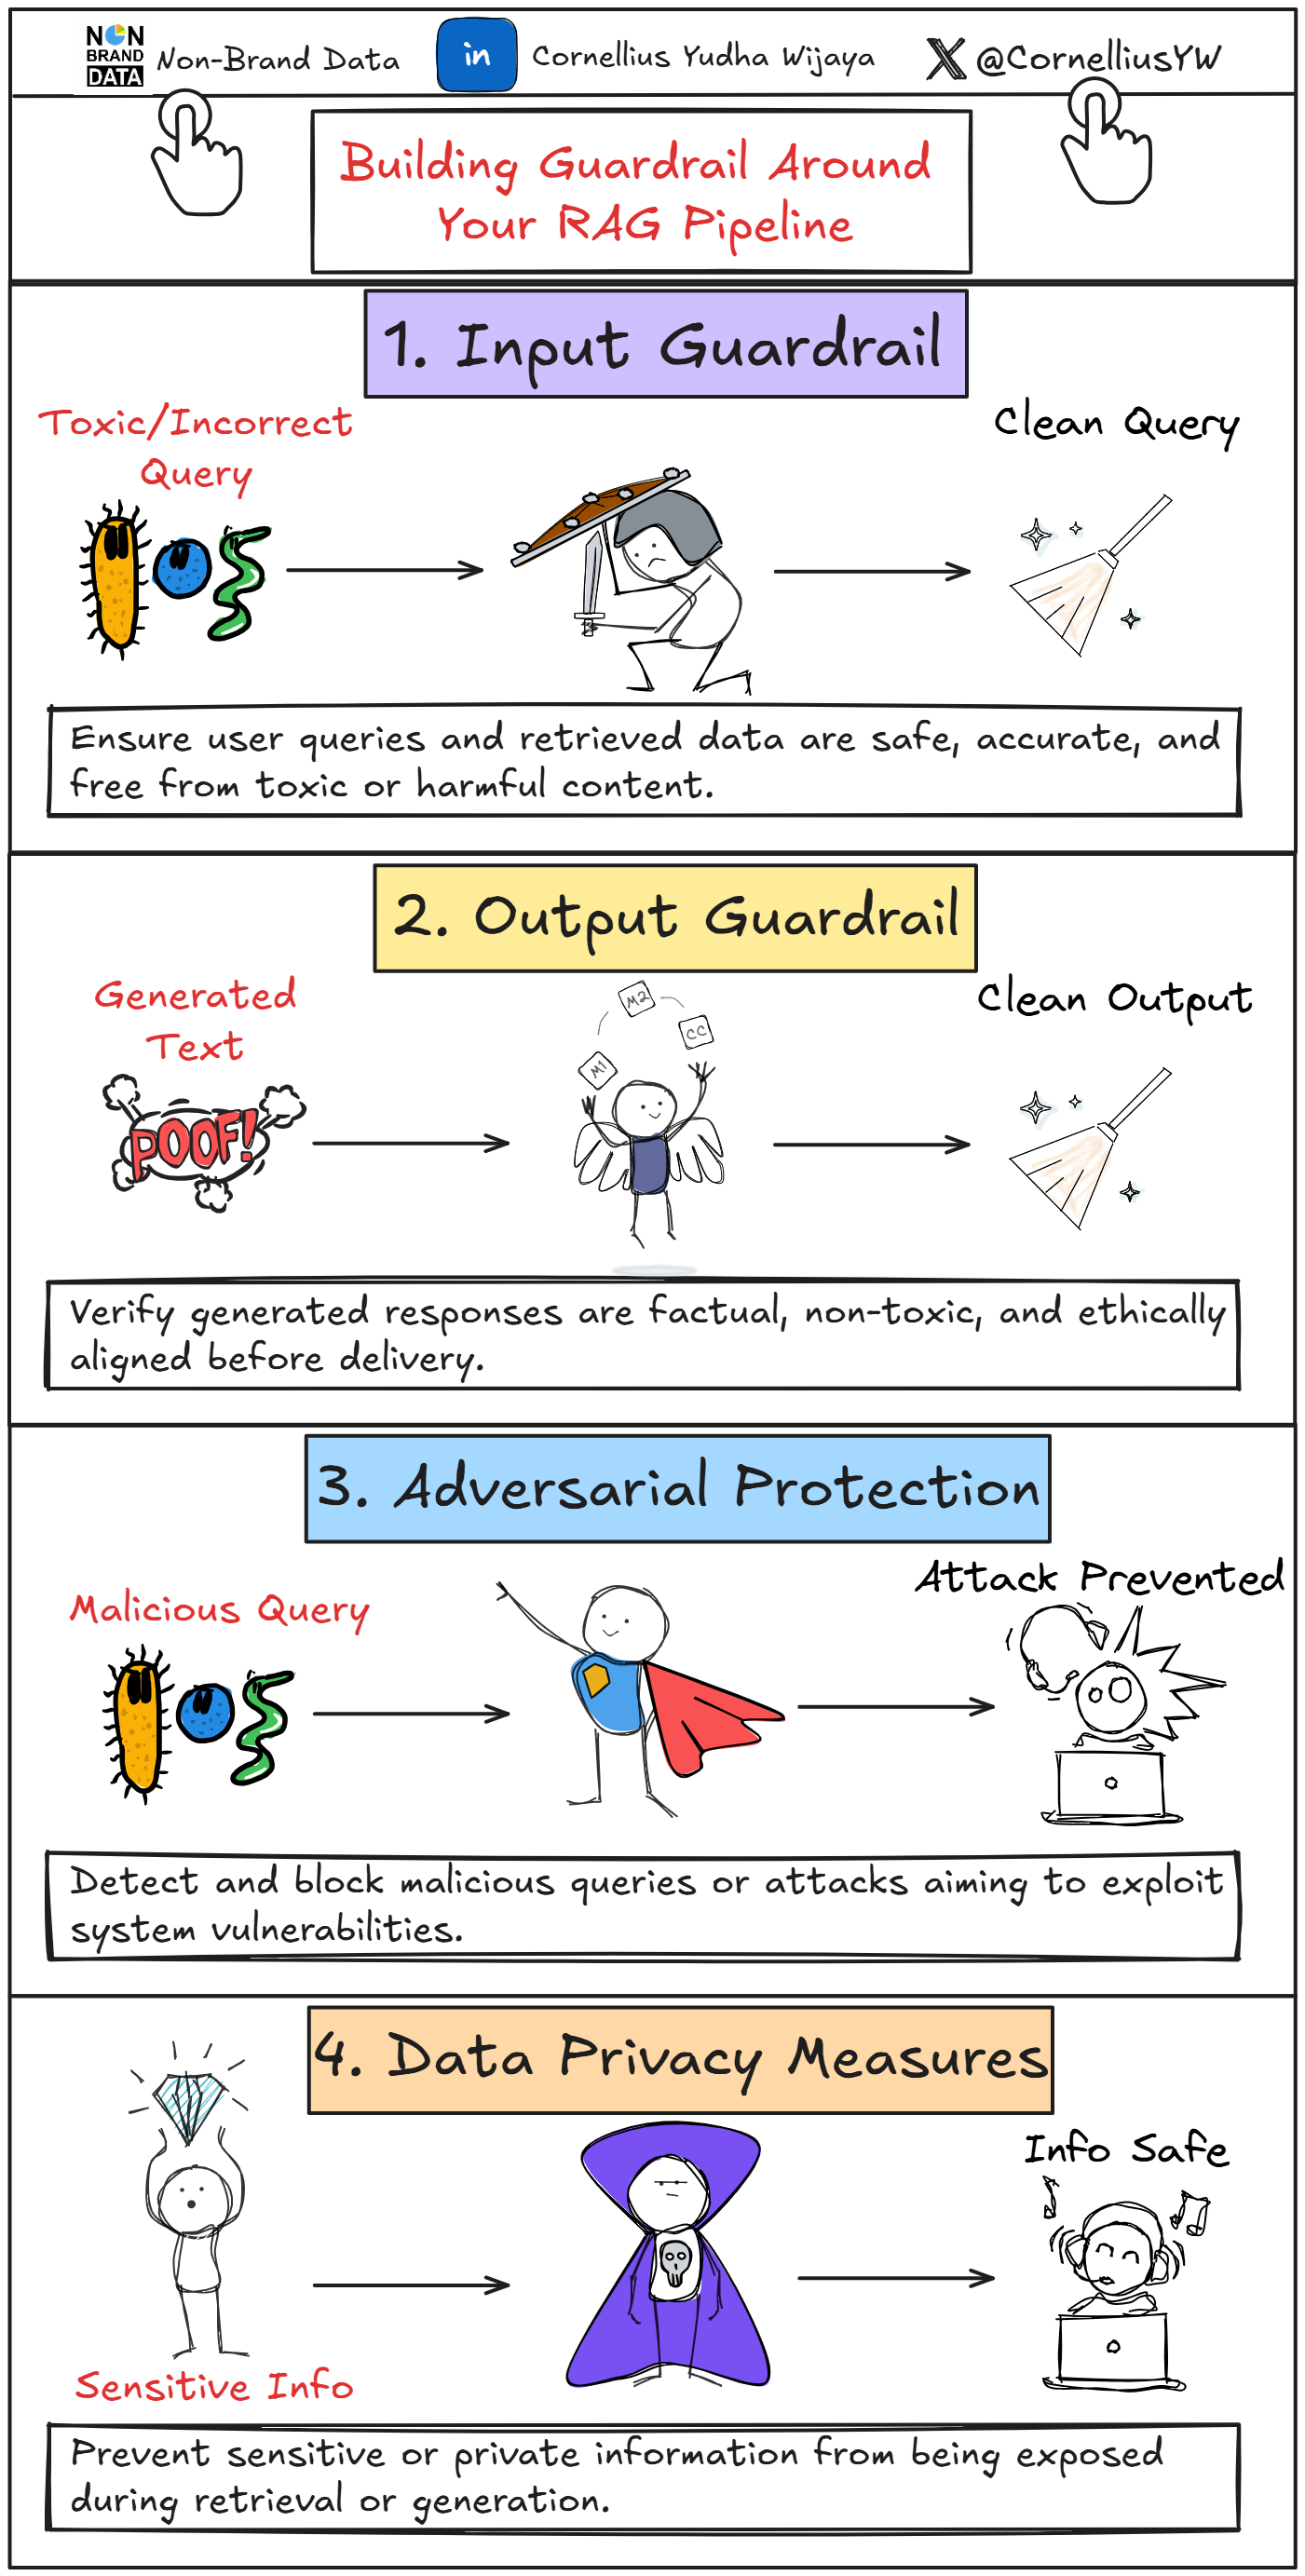

## Library Installation

Start by installing the library used in this Notebook.

In [1]:
!pip install -q chromadb pypdf2 sentence-transformers litellm langchain presidio-analyzer presidio-anonymizer detoxify
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Import the Libraries and set the environment variables

In [2]:
# Import libraries
import os
import PyPDF2
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings
import litellm
from litellm import completion
from langchain.text_splitter import RecursiveCharacterTextSplitter
from detoxify import Detoxify  # For toxic content detection
import re  # For adversarial pattern detection
from presidio_analyzer import AnalyzerEngine  # For PII detection
from presidio_anonymizer import AnonymizerEngine  # For PII redaction

# # Set environment variables. Uncomment this if you want to set them directly.
# os.environ["HUGGINGFACE_TOKEN"] = "your_huggingface_token_here"
# os.environ["GEMINI_API_KEY"] = "your_gemini_api_key_here"
os.environ['LITELLM_LOG'] = 'DEBUG'

# # Retrieve environment variables
# HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")
# GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'fields' has been removed
  warnings.warn(message, UserWarning)


## Extract Text from folder containing PDF files

In [3]:
def extract_text_from_pdfs(folder_path):
    all_text = ""
    for filename in os.listdir(folder_path):
        if filename.endswith(".pdf"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as file:
                reader = PyPDF2.PdfReader(file)
                for page in reader.pages:
                    all_text += page.extract_text()
    return all_text

pdf_folder = "dataset"
all_text = extract_text_from_pdfs(pdf_folder)

## Text Splitter

In [4]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # Size of each chunk
    chunk_overlap=50,  # Overlap between chunks to maintain context
    separators=["\n\n", "\n", " ", ""]  # Splitting hierarchy
)

chunks = text_splitter.split_text(all_text)

## Set up the Knowledge Base with ChromaDB and Generate Embeddings with sentence-transformers

In [5]:
# Initialize a persistent ChromaDB client
client = chromadb.PersistentClient(path="chroma_db")

# Load the SentenceTransformer model for text embeddings
text_embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Delete existing collection (if needed)
try:
    client.delete_collection(name="knowledge_base")
    print("Deleted existing collection: knowledge_base")
except Exception as e:
    print(f"Collection does not exist or could not be deleted: {e}")

# Create a new collection for text embeddings
collection = client.create_collection(name="knowledge_base")

# Add text chunks to the collection
for i, chunk in enumerate(chunks):
    # Generate embeddings for the chunk
    embedding = text_embedding_model.encode(chunk)

    # Add to the collection with metadata
    collection.add(
        ids=[f"chunk_{i}"],  # Unique ID for each chunk
        embeddings=[embedding.tolist()],  # Embedding vector
        metadatas=[{"source": "pdf", "chunk_id": i}],  # Metadata
        documents=[chunk]  # Original text
    )

Deleted existing collection: knowledge_base


## Perform Semantic Search with ChromaDB and Embedding Model

In [6]:
def semantic_search(query, top_k=2):
    # Generate embedding for the query
    query_embedding = text_embedding_model.encode(query)

    # Query the collection
    results = collection.query(
        query_embeddings=[query_embedding.tolist()],
        n_results=top_k
    )
    return results

# Example query
query = "What is the insurance for car?"
results = semantic_search(query)

# Display results
for i, result in enumerate(results['documents'][0]):
    print(f"Result {i+1}: {result}\n")

Result 1: insurance) 
FINANCIAL RESPONSIBILITY LAW
A state law requiring that all automobile 
drivers show proof that they can pay dam-
ages up to a minimum amount if involved 
in an auto accident. Varies from state to 
state but can be met by carrying a mini-
mum amount of auto liability insurance. 
(See Compulsory auto insurance)
FINITE RISK REINSURANCE
Contract under which the ultimate li-
ability of the reinsurer is capped and on 
which anticipated investment income is

Result 2: policyholder’s car from a collision. 
5. Comprehensive, for damage to the poli-
cyholder’s car not involving a collision 
with another car (including damage 
from fire, explosions, earthquakes, floods, and riots), and theft. 6. Uninsured motorists coverage, for costs 
resulting from an accident involving a hit-and-run driver or a driver who does not have insurance. 
AUTO INSURANCE PREMIUM
The price an insurance company charges 
for coverage, based on the frequency and



## Generate Repsonse Based on Semantic Search

In [9]:
# Set up LiteLLM with Gemini

def generate_response(query, context):
    # Combine the query and context for the prompt
    prompt = f"Query: {query}\nContext: {context}\nAnswer:"

    # Call the Gemini model via LiteLLM
    response = completion(
        model="gemini/gemini-1.5-flash",  # Use the Gemini model
        messages=[{"content": prompt, "role": "user"}],
        api_key= GEMINI_API_KEY
    )

    # Extract and return the generated text
    return response['choices'][0]['message']['content']

# Retrieve the top results from semantic search
search_results = semantic_search(query)
context = "\n".join(search_results['documents'][0])

# Generate a response using the retrieved context
response = generate_response(query, context)
print("Generated Response:\n", response)

Generated Response:
 Based on the provided text, car insurance is a type of liability insurance that helps drivers meet the requirements of state financial responsibility laws.  The text mentions several types of auto insurance coverage:

* **Liability insurance:** This covers damages to other people and their property if the policyholder is at fault in an accident.  The minimum amount required varies by state.
* **Collision:** Covers damage to the policyholder's car from a collision.
* **Comprehensive:** Covers damage to the policyholder's car not caused by a collision (e.g., fire, theft, natural disasters).
* **Uninsured/Underinsured motorists coverage:** Covers costs resulting from accidents involving drivers without or with insufficient insurance.

The price paid for this coverage is called the auto insurance premium.



## Setting up the Guardrails

We set up the functions for the following Guardrails:
1. Input Guardrails
2. Adversarial Protection
3. Data Privacy Measurement
4. Output Guardrails

In [20]:
def validate_input(query):
    """
    Use detoxify to detect toxic content in the query.
    """
    try:
        results = Detoxify('original').predict(query)
        if results['toxicity'] > 0.5:  # Threshold for toxicity
            raise ValueError("Query contains toxic or inappropriate content.")
        return True
    except Exception as e:
        return f"Input guardrail error: {e}"

def detect_adversarial_query(query):
    """
    Detect adversarial queries with unusual patterns or special characters.
    """
    try:
        if re.search(r"[^\w\s.,?]", query):  # Check for special characters
            raise ValueError("Query contains potentially adversarial patterns.")
        return True
    except Exception as e:
        return f"Adversarial protection error: {e}"

def detect_and_redact_pii(text):
    """
    Use Presidio to detect and redact PII in the text.
    """
    try:
        analyzer = AnalyzerEngine()
        anonymizer = AnonymizerEngine()
        results = analyzer.analyze(text=text, language="en")
        anonymized_text = anonymizer.anonymize(text=text, analyzer_results=results)
        return anonymized_text.text
    except Exception as e:
        return f"Data privacy error: {e}"

def ensure_length_limit(response, max_length=200):
    """
    Ensure the generated response does not exceed the specified length limit.
    """
    try:
        if len(response) > max_length:
            raise ValueError(f"Generated response exceeds the length limit of {max_length} characters.")
        return response
    except Exception as e:
        return f"Length limit guardrail error: {e}"

## Input Guardrails for detecting Toxic

In [21]:
# Example query
query = "I don't like the insurance because it's a scam and you are f*****g liar."

result = validate_input(query)
print(result)

Input guardrail error: Query contains toxic or inappropriate content.


## Advesarial Protection Guardrail

In [24]:
query = "What is the insurance for car? <script>alert('XSS')</script>"

#Detect any adversarial attack
result = detect_adversarial_query(query)
print(result)

Adversarial protection error: Query contains potentially adversarial patterns.


## Data Privacy Measure Guardrail

In [25]:
context = "John Doe lives at Street 123 Main and his phone number is +62808011111."

# Detect and redact PII in the context
result = detect_and_redact_pii(context)
print(result)

<PERSON> lives at <LOCATION> and his phone number is <NRP>.


## Output Guardrail for character limit

In [23]:
# Retrieve the top results from semantic search
search_results = semantic_search(query)
context = "\n".join(search_results['documents'][0])

# Generate a response using the retrieved context and check the limit
response = generate_response(query, context)
result = ensure_length_limit(response, max_length=100)
print(result)

Length limit guardrail error: Generated response exceeds the length limit of 100 characters.


## Combining the Guardrail with RAG pipeline

In [31]:
def secure_rag_pipeline(query):
    """
    Secure RAG Pipeline with integrated guardrails.
    Raises exceptions if any guardrail is triggered.
    """
    # Step 1: Input Guardrails
    validate_input(query)  # Raises ValueError if the query is toxic
    detect_adversarial_query(query)  # Raises ValueError if the query is adversarial

    # Step 2: Perform semantic search
    search_results = semantic_search(query)
    context = "\n".join(search_results['documents'][0])

    # Step 3: Data Privacy Measures
    safe_context = detect_and_redact_pii(context)  # Raises ValueError if PII detection fails

    # Step 4: Generate response
    response = generate_response(query, safe_context)

    # Step 5: Ensure response does not exceed the length limit
    limited_response = ensure_length_limit(response, max_length=1000)  # Raises ValueError if the response is too long

    # Step 6: Return the final safe and length-limited response
    return limited_response

## Example Query with Secure RAG Pipeline

In [32]:
# Example query
query = "What is the insurance for car?"

try:
    # Run the secure RAG pipeline
    response = secure_rag_pipeline(query)
    print("Generated Response:\n", response)
except ValueError as e:
    print(f"Guardrail triggered: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Generated Response:
 Based on the provided text, car insurance is described as a means of meeting a state's Financial Responsibility Law.  The law requires drivers to prove they can pay for damages caused in an accident, and this can be done by carrying a minimum amount of auto liability insurance.

The text also lists several types of car insurance coverage:

* **Liability insurance:** Covers damages to other people and their property.
* **Collision:** Covers damage to the policyholder's car from a collision.
* **Comprehensive:** Covers damage to the policyholder's car not involving a collision (fire, explosion, etc.), and theft.
* **Uninsured motorists coverage:** Covers costs from accidents involving uninsured or hit-and-run drivers.


The text mentions the "Auto Insurance Premium" as the price charged for this coverage.

